# Random Forest Algorithm

Random forests provide an improvement over bagged trees by way of a
small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of p predictors is chosen as split candidates from the full set of n predictors.The split is allowed to use only one of those m predictors.

`in building a random forest, at each split in the tree,
the algorithm is not even allowed to consider a majority of the available predictors. This may sound crazy, but it has a clever rationale.`

- suppose there is one predictor which is everytime the most powerful one to giv result. then other predictors/ features are not participating in the prediction.
- to remove this problem we are going to differenciate all the trees taken for the bunch by different sampling and different combination of features.
- there is good possiblity that the most powerful feature is not avalable in a bunch of trees.

`difference b/w bagging and Random Forest is number of features/ predictors used contextually`

## Bootstrap (Resampling)

The bootstrap is a widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method.

- here the samples are resampled with replacements(duplicate rows) and indexes are taken randomly from the sample.
- then this data is used to train the model
- due to this randomization and sampling it gives the model an idea/ opportunity to stop overfitting.

## Algorithm of sampling for Random Forest 

1. get number of features(n), number of samples(m)
2. generate random indexes(idxs) of size m with replacements and random indexes(feat-idxs) of size n without replacement(no duplicate features we want)
3. update input feature matrix(X) with size $(number_{idxs},number_{feat-idxs})$ using idxs and feat_idxs
4. update input target matrix(y) with idxs similarly

[applied in the class below]

## Random Forest Algorithm

1. initilaize 
    - number_of_trees we want to use
    - minimum number of features(min_features) we want to keep while sampling
    - max_depth of tree 
    - minimum node splitting size (min_samples_split)
    - criteria for information gain
2. take Decision Trees(Classification/ Regression) in quantity of number_of_trees apply tree's configurations from initial parameters.
3. resampling of data based on sampling algorithm above.
4. train all trees with the new data.
5. test the mode to see if it working or not (kind of an important one)

[implementation in class below]

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

## Random Forest Classifier Model

In [3]:

class RandomForestClassifier:
    """Ensemble method for classification 

    using a bunch of Decision Tree's to do to the classification.

    Args:
        num_of_trees (int, optional): number of trees in ensemble. Defaults to 50.
        min_features (int, optional): minimum number of features to use in every tree. Defaults to None.
        max_depth (int, optional): max depth of the every tree. Defaults to 100.
        min_samples_split (int, optional): minimum size ofsampels to split. Defaults to 2.
        criteria (str, optional): criteria to calcualte information gain. Defaults to 'gini'.
    """

    def __init__(self, num_of_trees: int = 25, min_features: int = None, max_depth: int = 50, min_samples_split: int = 2, criteria: str = 'gini') -> None:
        """constructor
        """
        self._X = None
        self._y = None
        self._feature_names = None
        self._target_name = None
        self._trees = []
        self.num_of_trees = num_of_trees
        self.min_features = min_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criteria = criteria

    def _sampling(self) -> Tuple[List[int], List[int]]:
        """sampling function

        Returns:
            Tuple[List[int],List[int]]: sampling idxs for rows nad columns for feature and target matrix.
        """
        m, n = self._X.shape

        # sampling with replacement
        # means rows with repeat in the data
        # statitistically it gives an edge for data prediction
        idxs = np.random.randint(low=0, high=m, size=m)

        # feature sampling to decrease correlation between trees
        if self.min_features is None:
            size = n
        else:
            size = n if self.min_features > n else self.min_features

        feat_idxs = np.random.choice(n, size=size, replace=False)
        return idxs, feat_idxs

    def train(self, X: Union[np.ndarray, list], y: Union[np.ndarray, list], feature_name: list = None, target_name: list = None) -> None:
        """Train the model

        Args:
            X (Union[np.ndarray,list]): feature matrix
            y (Union[np.ndarray,list]): target matrix
            feature_name (str, optional): feature names. Defaults to None.
            target_name (str, optional): target names. Defaults to None.
        """

        X = np.array(X, dtype='O') if not isinstance(
            X, (np.ndarray)) else X  # converting to numpy array
        y = np.array(y, dtype='O') if not isinstance(
            y, (np.ndarray)) else y  # converting to numpy array
        # reshaping to vectors
        self._X = X.reshape(-1, 1) if len(X.shape) == 1 else X
        self._y = y.reshape(-1, 1) if len(y.shape) == 1 else y

        # creating feature names if not mentioned
        self._feature_names = feature_name or [
            f"C_{i}" for i in range(self._X.shape[1])]

        # creating target name if not mentioned
        self._target_name = target_name or ['target']

        for _ in range(self.num_of_trees):
            clf = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criteria=self.criteria
            )
            idxs, feat_idxs = self._sampling()
            X_sampled = self._X[idxs, :][:, feat_idxs]
            y_sampled = self._y[idxs]

            clf.train(
                X=X_sampled,
                y=y_sampled,
                feature_name=[self._feature_names[i] for i in feat_idxs],
                target_name=self._target_name
            )

            self._trees.append([clf, feat_idxs])

    @staticmethod
    def _get_max_result(a: np.ndarray) -> Union[str, int, None]:
        """get max result from the bunch of classification results

        Args:
            a (np.ndarray): input array for category

        Returns:
            Union[str,int,None]: max count class/category
        """
        unique_values = np.unique(a, return_counts=True)
        zipped = zip(*unique_values)
        max_count = 0
        result = None
        for i in zipped:
            if i[1] > max_count:
                result = i[0]
                max_count = i[1]
        return result

    def predict(self, X: np.ndarray) -> np.ndarray:
        """predict results

        Args:
            X (np.ndarray): test matrix.

        Raises:
            ValueError: X should be list or numpy array.

        Returns:
            np.ndarray: prediction results.
        """

        if isinstance(X, (np.ndarray, list)):
            X = np.array(X, dtype='O') if not isinstance(X, (np.ndarray)) else X

            results = []
            for clf, feat_idxs in self._trees:
                result = clf.predict(X[:, feat_idxs])
                results.append(result)

            all_tree_results = np.concatenate(np.array(results, dtype='O'), axis=1)
            final_results = np.apply_along_axis(
                func1d=self._get_max_result, axis=1, arr=all_tree_results).reshape(-1, 1)
            return final_results
        else:
            raise ValueError("X should be list or numpy array")



### Testing with data

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = load_iris()

X = dataset.data
y = dataset.target
feature_name = dataset.feature_names
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.10)

rf_clf = RandomForestClassifier(num_of_trees=100,min_features=2)
rf_clf.train(X=X_train,y=y_train,feature_name=feature_name)


y_pred = rf_clf.predict(X_test)

In [5]:
df = pd.DataFrame(np.concatenate((y_test.reshape(-1,1),y_pred),axis=1),columns=['original','predicted'])
df

original  predicted
0          1          1
1          0          0
2          2          2
3          1          1
4          1          2
5          0          0
6          1          1
7          2          2
8          1          1
9          1          1
10         2          2
11         0          0
12         0          0
13         0          0
14         0          0

## Random Forest Regressor Model

In [8]:
class RandomForestRegressor:
    """Ensemble method for regression 

    using a bunch of Decision Tree's to do to the regression.

    Args:
        num_of_trees (int, optional): number of trees in ensemble. Defaults to 50.
        min_features (int, optional): minimum number of features to use in every tree. Defaults to None.
        max_depth (int, optional): max depth of the every tree. Defaults to 100.
        min_samples_split (int, optional): minimum size ofsampels to split. Defaults to 2.
        criteria (str, optional): criteria to calcualte information gain. Defaults to 'gini'.
    """

    def __init__(self, num_of_trees: int = 25, min_features: int = None, max_depth: int = 30, min_samples_split: int = 3, criteria: str = 'variance') -> None:
        self._X = None
        self._y = None
        self._feature_names = None
        self._target_name = None
        self._trees = []
        self.num_of_trees = num_of_trees
        self.min_features = min_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criteria = criteria

    def _sampling(self) -> Tuple[List[int], List[int]]:
        """sampling function

        Returns:
            Tuple[List[int],List[int]]: sampling idxs for rows nad columns for feature and target matrix.
        """
        m, n = self._X.shape

        # sampling with replacement
        # means rows with repeat in the data
        # statitistically it gives an edge for data prediction
        idxs = np.random.randint(low=0, high=m, size=m)

        # feature sampling to decrease correlation between trees
        if self.min_features is None:
            size = n
        else:
            size = n if self.min_features > n else self.min_features

        feat_idxs = np.random.choice(n, size=size, replace=False)
        return idxs, feat_idxs

    def train(self, X: Union[np.ndarray, list], y: Union[np.ndarray, list], feature_name: list = None, target_name: list = None) -> None:
        """Train the model

        Args:
            X (Union[np.ndarray,list]): feature matrix.
            y (Union[np.ndarray,list]): target matrix.
            feature_name (list, optional): feature names. Defaults to None.
            target_name (list, optional): target name. Defaults to None.
        """

        X = np.array(X, dtype='O') if not isinstance(
            X, (np.ndarray)) else X  # converting to numpy array
        y = np.array(y, dtype='O') if not isinstance(
            y, (np.ndarray)) else y  # converting to numpy array
        # reshaping to vectors
        self._X = X.reshape(-1, 1) if len(X.shape) == 1 else X
        self._y = y.reshape(-1, 1) if len(y.shape) == 1 else y

        # creating feature names if not mentioned
        self._feature_names = feature_name or [
            f"C_{i}" for i in range(self._X.shape[1])]

        # creating target name if not mentioned
        self._target_name = target_name or ['target']

        for _ in range(self.num_of_trees):

            reg = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criteria=self.criteria
            )
            idxs, feat_idxs = self._sampling()  # get sampling idxs
            X_sampled = self._X[idxs, :][:, feat_idxs]
            y_sampled = self._y[idxs]

            reg.train(
                X=X_sampled,
                y=y_sampled,
                feature_name=[self._feature_names[i] for i in feat_idxs],
                target_name=self._target_name
            )

            self._trees.append([reg, feat_idxs])

    def predict(self, X: Union[np.ndarray, list]) -> np.ndarray:
        """predict regression result

        Args:
            X (Union[np.ndarray, list]): test matrix.

        Raises:
            ValueError: X should be list or numpy array.

        Returns:
            np.ndarray: regression results.
        """
        if isinstance(X, (np.ndarray, list)):
            X = np.array(X, dtype='O') if not isinstance(X, (np.ndarray)) else X

            results = []
            for reg, feat_idxs in self._trees:
                result = reg.predict(X[:, feat_idxs])
                results.append(result)

            all_tree_results = np.concatenate(np.array(results, dtype='O'), axis=1)
            final_results = np.mean(all_tree_results, axis=1).reshape(-1, 1)
            return final_results
        else:
            raise ValueError("X should be list or numpy array")

### Testing with data

In [9]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd

boston_dataset = load_boston()

dataset = pd.DataFrame(data=boston_dataset['data'],columns=boston_dataset.feature_names)
dataset['target'] = boston_dataset["target"]

X = dataset[["RM","AGE","DIS","LSTAT"]].values
y = boston_dataset.target.reshape(-1,1)

feature_name = ["RM","AGE","DIS","LSTAT"]
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.10)

rf_reg = RandomForestRegressor(min_features=3,max_depth=50,min_samples_split=3)
rf_reg.train(X=X_train,y=y_train,feature_name=list(feature_name))
y_pred = rf_reg.predict(X_test)

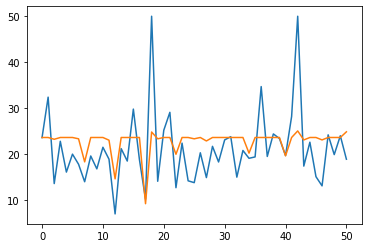

54.13973910785093

In [10]:
df = pd.DataFrame(np.concatenate((y_test.reshape(-1,1),y_pred),axis=1),columns=['original','predicted'])

plt.plot(df['original'])
plt.plot(df['predicted'])
plt.show()

from sklearn.metrics import mean_squared_error

mean_squared_error(df['original'],df['predicted'])